In [3]:
import pandas as pd
from tqdm.auto import tqdm
import random
import torch
import os
import numpy as np
import random
import matplotlib.pyplot as plt

In [1]:
!pip install lightning
!pip install torchmetrics
!pip install huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 42.2 MB/s eta 0:00:0000:01


In [34]:
from huggingface_hub import notebook_login

notebook_login()

## Split data

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(42)

In [6]:

# ignore class 0
data = data.loc[data['label'] > 0]
products = []
for idx,(product, group_data) in tqdm(enumerate(data.groupby("product"))):
    products.append(product)
random.shuffle(products)

train_ratio = 0.7
val_ratio = 0.15

size = len(products)

train = data.loc[data['product'].isin(products[:int(size*train_ratio)])]
val = data.loc[data['product'].isin(products[int(size*train_ratio):int(size*(train_ratio+val_ratio))])]
test = data.loc[data['product'].isin(products[int(size*(train_ratio+val_ratio)):])]

print(f"Number of train products: {len(train.groupby('product'))} --- Size: {len(train)}")
print(f"Number of validation products: {len(val.groupby('product'))} --- Size: {len(val)}")
print(f"Number of test products: {len(test.groupby('product'))} --- Size: {len(test)}")

0it [00:00, ?it/s]

Number of train products: 143 --- Size: 3398
Number of validation products: 31 --- Size: 682
Number of test products: 31 --- Size: 835


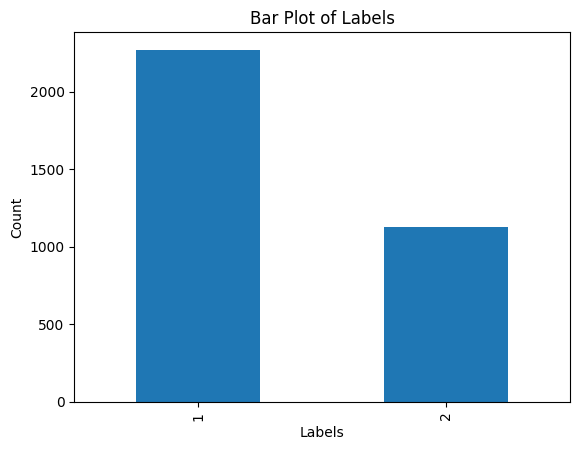

In [15]:
# Đếm số lượng mỗi nhãn trong cột label
label_counts = train['label'].value_counts()

# Vẽ bar plot
label_counts.plot(kind='bar')

# Thiết lập tiêu đề và nhãn cho trục x và y
plt.title('Bar Plot of Labels')
plt.xlabel('Labels')
plt.ylabel('Count')

# Hiển thị biểu đồ
plt.show()

## Select max length

In [7]:
token_len = []

for idx,row in data.iterrows():
    token_len.append(len(row['comment'].split(" ")))
    
token_len = torch.tensor(token_len).float()

print(f"Mean: {token_len.mean()} Std: {token_len.std()}")
# select max length = 100 

Mean: 32.50905227661133 Std: 17.861324310302734


# Map class to idx

In [8]:
classes = set(data['label'].values.tolist())
classes_to_idx = {cls_name:idx for idx,cls_name in enumerate(classes)}
idx_to_classes = {idx: 'positive' if cls_name == 1 else 'negative' for idx,cls_name in enumerate(classes)}
classes_to_idx,idx_to_classes,classes

({1: 0, 2: 1}, {0: 'positive', 1: 'negative'}, {1, 2})

# Build dataset

In [9]:
# build dataset
import matplotlib.pyplot as plt
from transformers import BertTokenizer
from torch.utils.data import Dataset , DataLoader
class Reviews(Dataset):
    def __init__(self,data,classes_to_idx,max_seq_len = 100):
        super(Reviews,self).__init__()
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
        self.data = data
        self.max_seq_len = max_seq_len
        self.classes_to_idx = classes_to_idx
        self.plot = False
        
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        sample = self.data.iloc[idx]
        comment = sample['comment']
        comment = comment.lower().replace("\n",' ').replace('\r'," ")
        comment = self.tokenizer(comment, return_tensors="pt",padding = 'max_length', truncation = True,max_length = self.max_seq_len)
        comment = {key:value.squeeze() for key,value in comment.items()}
        label = self.classes_to_idx[sample['label']]

        return comment,label

# Build model

In [10]:
from transformers import BertModel
from torch import nn
import torch
from huggingface_hub import PyTorchModelHubMixin

class ReviewsClassification(nn.Module,PyTorchModelHubMixin):
    def __init__(self,n_classes):
        super(ReviewsClassification,self).__init__()
        self.feature_extractor = BertModel.from_pretrained("bert-base-multilingual-cased")
        self.head = nn.Linear(768,n_classes)
    def forward(self, text_inputs):
        outputs = self.feature_extractor(**text_inputs)
        cls_token = outputs.last_hidden_state[:,0]
        y = self.head(cls_token)
        return y
        

## Buid Module

In [24]:
import lightning.pytorch as L
from torchmetrics.functional import accuracy, f1_score
class ReviewsClassification_Module(L.LightningModule):
    def __init__(self,train_data,val_data,test_data,classes_to_idx,lr,weight_decay,max_epochs,**kwargs):
        self.save_hyperparameters()
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.classes_to_idx = classes_to_idx
        
        self.lr = lr
        self.weight_decay = weight_decay
        self.max_epochs = max_epochs
        self.loss_func = nn.CrossEntropyLoss()
        self.model = ReviewsClassification( n_classes = n_classes) 
        self.num_classes = n_classes
    def setup(self, stage: str):
        if stage == "fit":
            self.train_dataset = Reviews(
                data = self.train_data,
                classes_to_idx= self.classes_to_idx
                )
            self.val_dataset = Reviews(
                data = self.val_data ,
                classes_to_idx= self.classes_to_idx
                )
        if stage == "test":
            self.test_dataset = Reviews(
                data = self.test_data ,
                classes_to_idx= self.classes_to_idx
                )
    def forward(self,text):
        return self.model(text)

    def training_step(self, batch, batch_idx):
        text, y = batch
        y_hat = self(text)
        loss = self.loss_func(y_hat, y)
       
        y_pred = torch.softmax(y_hat, dim=-1)

        # Logging to TensorBoard by default
        self.log("train_loss", loss, prog_bar=True,on_step=True, on_epoch=True)
        self.log("train_acc", accuracy(y_pred, y, task="multiclass", num_classes=self.num_classes), prog_bar=True,on_step=True, on_epoch=True)
        self.log("train_f1", f1_score(y_pred, y, task="multiclass",average = 'macro', num_classes=self.num_classes), prog_bar=True,on_step=True, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        text, y = batch
        y_hat = self(text)

        loss = self.loss_func(y_hat, y)

        y_pred = torch.softmax(y_hat, dim=-1)

        # Logging to TensorBoard by default
        self.log("val_loss", loss, prog_bar=True,on_step=False, on_epoch=True)
        self.log("val_acc", accuracy(y_pred, y, task="multiclass", num_classes=self.num_classes), prog_bar=True,on_step=False, on_epoch=True)
        self.log("val_f1", f1_score(y_pred, y, task="multiclass",average = 'macro', num_classes=self.num_classes), prog_bar=True,on_step=False, on_epoch=True)

        return loss
    def test_step(self, batch, batch_idx):
        # OPTIONAL
        text, y = batch
        y_hat = self(text)

        y_pred = torch.softmax(y_hat, dim=-1)

        self.log("test_acc", accuracy(y_pred, y, task="multiclass", num_classes=self.num_classes), prog_bar=True,on_step=False, on_epoch=True)
        self.log("test_f1", f1_score(y_pred, y, task="multiclass",average = 'macro', num_classes=self.num_classes), prog_bar=True,on_step=False, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        if self.max_epochs is not None:
            lr_scheduler = torch.optim.lr_scheduler.StepLR(
                optimizer=optimizer,step_size = 10, gamma=0.7
            )
            return [optimizer], [lr_scheduler]
        else:
            return optimizer
        
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=64,shuffle = True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=64)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=64)
        

In [30]:
import lightning.pytorch as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from  lightning.pytorch.callbacks import ModelCheckpoint

lr = 5e-5
weight_decay = 1e-4
max_epochs = 60
n_classes = 2 # Positive or Negative

trainer = L.Trainer(
    callbacks=[
        EarlyStopping(monitor="val_loss", mode="min",min_delta=0.00, patience=15,check_finite = True ),
        ModelCheckpoint(dirpath="/kaggle/working/", save_top_k=1, monitor="val_loss",save_last = True)
              ],
    max_epochs=max_epochs,
    accelerator="auto", devices='auto',
    gradient_clip_val=1,
    log_every_n_steps = 1
)
model = ReviewsClassification_Module(train,val,test,classes_to_idx,lr,weight_decay,max_epochs)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


In [31]:
trainer.fit(model)

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /kaggle/working exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type                  | Params
----------------------------------------------------
0 | loss_func | CrossEntropyLoss      | 0     
1 | model     | ReviewsClassification | 177 M 
----------------------------------------------------
177 M     Trainable params
0         Non-trainable params
177 M     Total params
711.420   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [32]:
trainer.test(model,ckpt_path = '/kaggle/working/epoch=0-step=54-v1.ckpt')

INFO: Restoring states from the checkpoint path at /kaggle/working/epoch=0-step=54-v1.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /kaggle/working/epoch=0-step=54-v1.ckpt
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.912574827671051     │
│          test_f1          │    0.9013996124267578     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.912574827671051, 'test_f1': 0.9013996124267578}]

In [35]:
model = ReviewsClassification_Module.load_from_checkpoint("/kaggle/working/epoch=0-step=54-v1.ckpt")

In [36]:
# save locally
model.model.save_pretrained("shopee_reviews_cls_no_product_name")

# push to the hub
model.model.push_to_hub("shopee_reviews_cls_no_product_name")

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/NCTuanAnh/shopee_reviews_cls_no_product_name/commit/02b7233f1219e1fa43613ccc18a94b9e7cf3d1e4', commit_message='Push model using huggingface_hub.', commit_description='', oid='02b7233f1219e1fa43613ccc18a94b9e7cf3d1e4', pr_url=None, pr_revision=None, pr_num=None)

## Inference

In [40]:
class ReviewsClassificationInference:
    def __init__(self,device = 'cpu'):
        self.model = ReviewsClassification.from_pretrained("NCTuanAnh/shopee_reviews_cls_no_product_name").to(device)
        self.model.eval()
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
        self.idx_to_class = {
            0:'positive',
            1:'negative'
        }
        self.device = device
    def __call__(self, comment):
        comment = comment.lower().replace("\n",' ').replace('\r'," ")
        comment = self.tokenizer(comment, return_tensors="pt")
        comment = {key:value.to(self.device) for key,value in comment.items()}
        output = self.model(comment).argmax(dim = -1).item()
        
        return self.idx_to_class[output]
model = ReviewsClassificationInference(device = 'cuda')   

config.json:   0%|          | 0.00/20.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

In [52]:
model('Không hiệu quả mua về vứt')

'negative'